In [1]:
import sys
import math
import pandas as pd
import numpy as np
import causalimpact as ci
import json
import matplotlib.pyplot as plt
import warnings

sys.path.append('c:\\Users\\Jordi Cremades\\Documents\\Repository')

from Utilities import reader_writer
from Utilities import query_engines

rw = reader_writer.Reader_Writer()

# SPM test Analysis

**Context**
<br>
After we carry out a test, we use a method known as synthetic control to decide if the results of the test are significant.
<br>
<br>
In this case, we will use the post-treatment period from the synthetic control (group configuration) for the pre-test period of this analysis. This is because the group structure was chosen specifically to best predict the post-treatment period of the first test (group configuration).
<br>
<br>
**Approach**
For synthetic control analysis I use the following convetions:
- We use the group structure defined in the earlier group set up phase.
- The post period in the group set up phase should be used as the pre-test period in the test analysis.

### Collect and classify data

In [2]:
# We load the stores that where present in the test
d_stores = rw.csv_read_file('SPM_group_creator_CARR_GE.csv')
d_stores

,store_address,Group
0,136826,Treat
1,136828,Treat
2,136829,Treat
3,136830,Treat
4,136831,Treat
5,136832,Treat
6,137063,Treat
7,137064,Treat
8,137065,Treat
9,137066,Treat


In [3]:
# Enrich d_stores with Orders and PNA Orders information

# Parameters
start_date = '2023-05-08'
end_date = '2023-06-11'
store_addresses = ",".join(str(val) for val in d_stores['store_address'].unique().tolist())

# Params
params = [
    {'name':'store_addresses', 'value':store_addresses}
    ,{'name':'start_date', 'value':start_date}
    ,{'name':'end_date', 'value':end_date}
]

# Query
query = query_engines.QueryEngines(
    query='SPM/SPM_group_creator.sql', 
    del1='--v2', 
    del2='--end_v2',
    params=params,
    output_dir=None,
    output_file=None,
    printq=None
)

d_pna = query.query_run_starbust()

c:\Users\Jordi Cremades\Documents\Repository\Utilities\query_engines.py:154: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


In [4]:
# Merge the information with the interested store_addresses
d_filtered = pd.merge(d_stores
    ,d_pna
    ,left_on=['store_address']
    ,right_on=['order_descriptors.store_address_id']
    ,how='inner')

# Delete unnecessary columns
d_filtered.drop(columns=['order_descriptors.store_address_id'], inplace=True)

# Rename columns
d_filtered = d_filtered.rename(columns={'store_address': 'store_address'
    ,'order_descriptors.order_activated_local_date': 'date'
    ,'number_of_products_with_pna': 'products_pna'
    ,'number_of_placed_products': 'products_placed'
    ,'number_of_orders': 'orders'})

print('There are {} distinct dates'.format(d_filtered['date'].nunique()))
print("Min Date = {}".format(d_filtered['date'].min()))
print("Max Date = {}".format(d_filtered['date'].max()))
print('There are {} store addresses'.format(d_filtered['store_address'].nunique()))
print('There are {} Control store addresses'.format(d_filtered[d_filtered['Group']=='Control']['store_address'].nunique()))
print('There are {} Treat store addresses'.format(d_filtered[d_filtered['Group']=='Treat']['store_address'].nunique()))
print('There are {} orders'.format(d_filtered['orders'].sum()))
print('There are {} pna products'.format(d_filtered['products_pna'].sum()))
print('There are {} placed products'.format(d_filtered['products_placed'].sum()))
warnings.filterwarnings('ignore')
d_filtered

There are 34 distinct dates
Min Date = 2023-05-08
Max Date = 2023-06-10
There are 24 store addresses
There are 5 Control store addresses
There are 19 Treat store addresses
There are 11420 orders
There are 4440 pna products
There are 85384 placed products


,store_address,Group,date,products_pna,products_placed,orders
0,136826,Treat,2023-06-03,5,293,38
1,136826,Treat,2023-06-01,8,273,31
2,136826,Treat,2023-05-19,1,265,35
3,136826,Treat,2023-05-13,5,250,31
4,136826,Treat,2023-05-23,1,313,42
...,...,...,...,...,...,...
519,439959,Treat,2023-06-04,0,5,2
520,439959,Treat,2023-05-18,0,10,2
521,439959,Treat,2023-05-10,3,39,2
522,439959,Treat,2023-06-02,0,2,1


### Synthetic control

In [5]:
# Parameters
start_pre = "2023-05-08"; end_pre = "2023-05-23"
start_post = "2023-05-24"; end_post = "2023-06-9"
target_columns = ['orders', 'UIPO', 'perc_products_pna']

# Prepare data
series = pd.Series(d_filtered['store_address'].unique())
pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
post_period = [pd.to_datetime(date) for date in [start_post, end_post]]

df_ready = d_filtered.groupby(['date', 'Group'])['products_pna','products_placed','orders'].sum().reset_index()
df_ready['UIPO'] = df_ready['products_placed']/df_ready['orders']
df_ready['perc_products_pna'] = df_ready['products_pna']/df_ready['products_placed']

# Orders
df_pivot = df_ready.pivot(index='date', columns='Group', values='orders')
df_pivot.dropna(how='any', inplace=True)
model_orders = ci.CausalImpact(df_pivot[['Treat', 'Control']],pre_period,post_period)

# UIPO
df_pivot = df_ready.pivot(index='date', columns='Group', values='UIPO')
df_pivot.dropna(how='any', inplace=True)
model_uipo = ci.CausalImpact(df_pivot[['Treat', 'Control']],pre_period,post_period)

# Perc_products_pna
df_pivot = df_ready.pivot(index='date', columns='Group', values='perc_products_pna')
df_pivot.dropna(how='any', inplace=True)
model_perc_products_pna = ci.CausalImpact(df_pivot[['Treat', 'Control']],pre_period,post_period)

### Models

model_orders, with a p_value of 0.0969030969030969
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 249.18. In the absence of an
intervention, we would have expected an average response of 265.71.
The 95% interval of this counterfactual prediction is [241.85, 288.95].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -16.53 with a 95% interval of
[-39.78, 7.33]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 4236.0.
Had the intervention not taken place, we would have expected
a sum of 4517.09. The 95% interval of this prediction is [4111.44, 4912.21].


The above results are given in terms of absolute numbers. In re

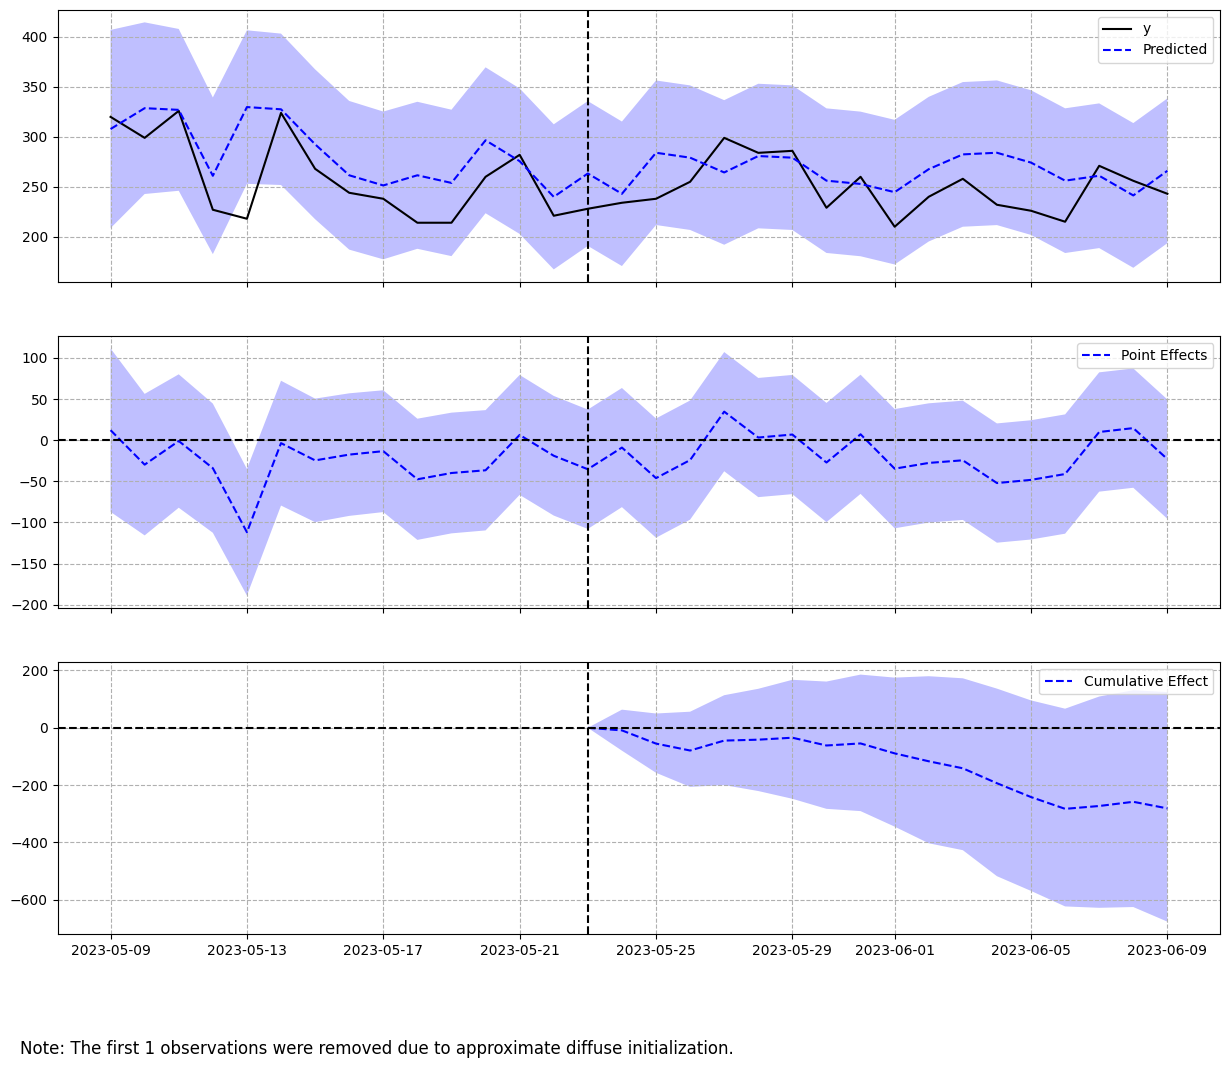

In [6]:
print('model_orders, with a p_value of {}'.format(model_orders.p_value))
print(model_orders.summary('report'))
model_orders.plot()

model_uipo, with a p_value of 0.00999000999000999
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 7.29. By contrast, in the absence of an
intervention, we would have expected an average response of 7.61.
The 95% interval of this counterfactual prediction is [7.36, 7.87].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -0.33 with a 95% interval of
[-0.58, -0.07]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 123.9.
By contrast, had the intervention not taken place, we would have expected
a sum of 129.43. The 95% interval of this prediction is [125.04, 133.82].


The above results are given in terms of absolute nu

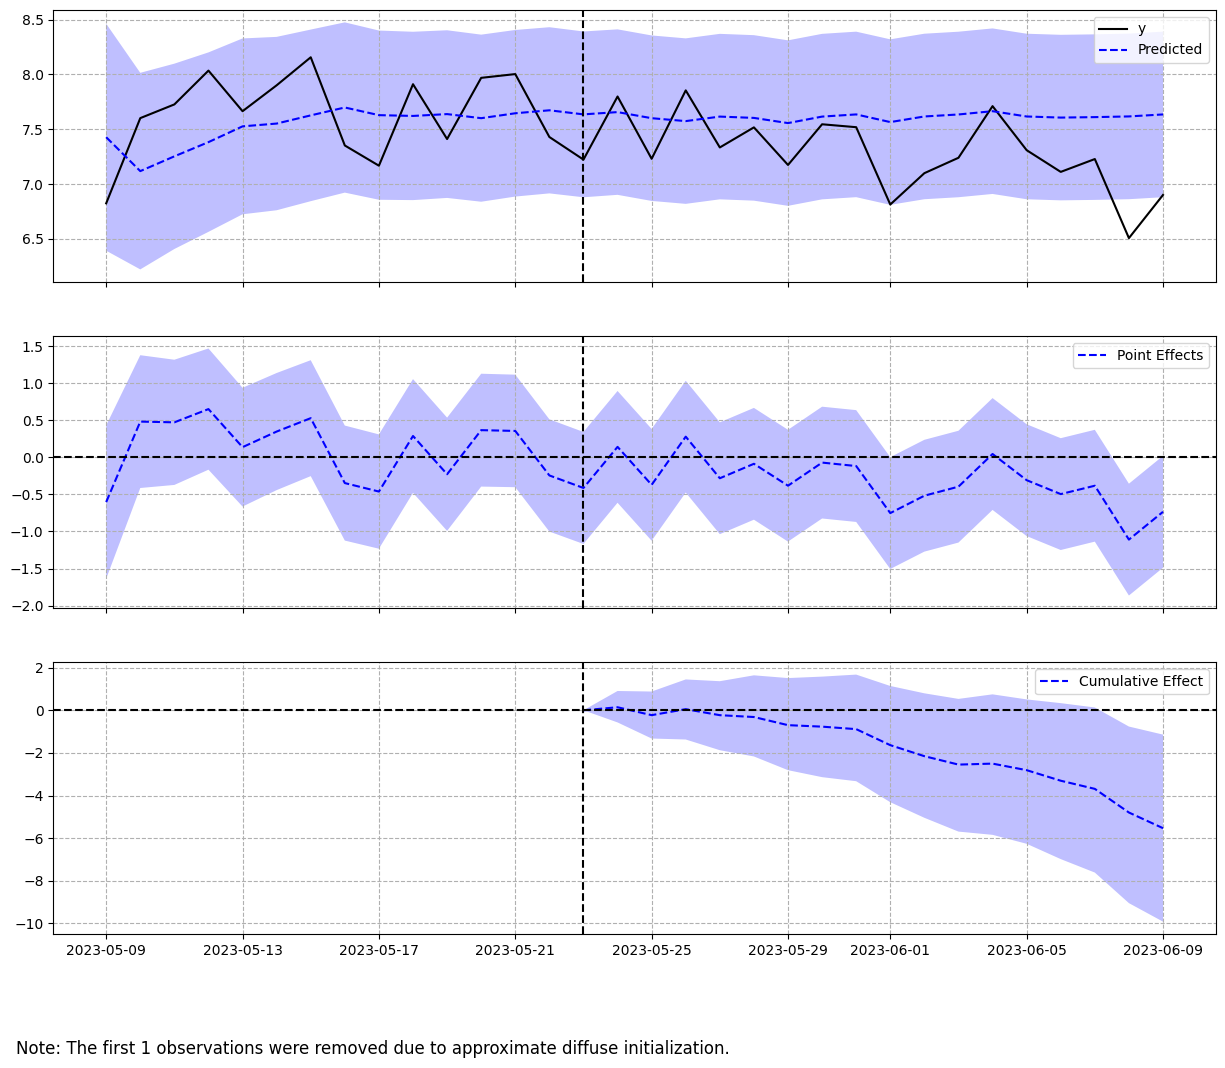

In [7]:
print('model_uipo, with a p_value of {}'.format(model_uipo.p_value))
print(model_uipo.summary('report'))
model_uipo.plot()

model_perc_products_pna plot, with a p_value of 0.000999000999000999
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.06. By contrast, in the absence of an
intervention, we would have expected an average response of 0.04.
The 95% interval of this counterfactual prediction is [0.03, 0.05].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[0.01, 0.02]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 0.98.
By contrast, had the intervention not taken place, we would have expected
a sum of 0.74. The 95% interval of this prediction is [0.57, 0.89].


The above results are given in terms of ab

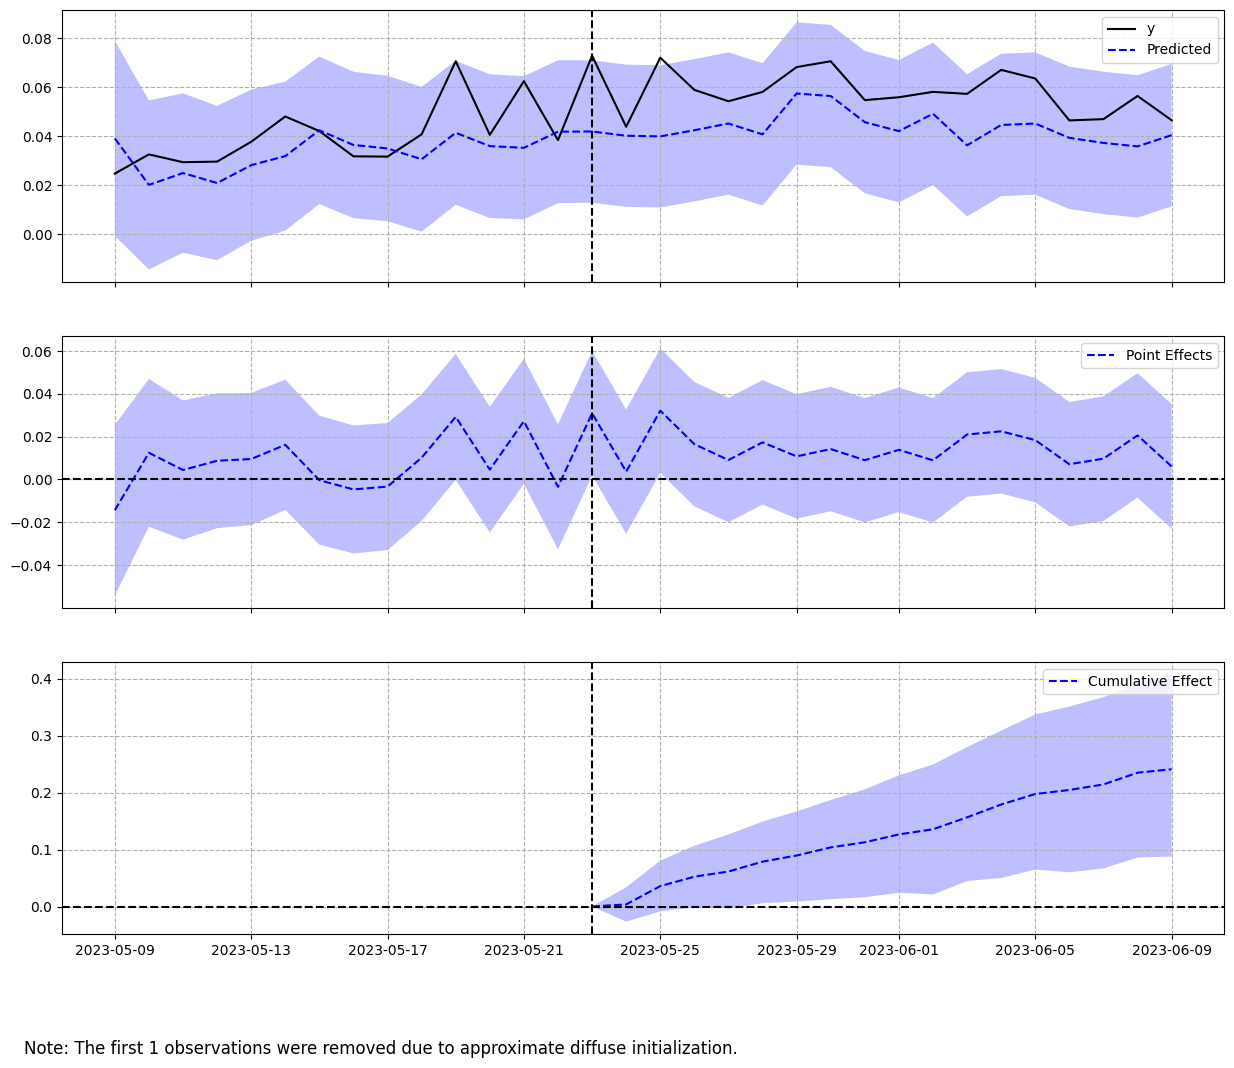

In [8]:
print('model_perc_products_pna plot, with a p_value of {}'.format(model_perc_products_pna.p_value))
print(model_perc_products_pna.summary('report'))
model_perc_products_pna.plot()